<a href="https://colab.research.google.com/github/soufianeze/MachineLearning2/blob/main/Bloc_4_Machine_learning_disaster_tweet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# importer des bibliothèques necessaires pour le projet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import en_core_web_sm
from sklearn.metrics import confusion_matrix
import tensorflow as tf 
import re
import string
from spacy.lang.en.stop_words import STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import recall_score, precision_score
import tensorflow as tf 
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.metrics import recall_score, precision_score
from wordcloud import WordCloud

In [4]:
# Installation Spacy Anglais
import sys
!{sys.executable} -m pip install spacy -q
!{sys.executable} -m spacy download en -q

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     |████████████████████████████████| 12.8 MB 17.0 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [5]:
# Importation des fichiers Train.csv, test.csv et sample_submission.csv depuis le répertoire personnel github

! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/train.csv
! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/test.csv
! wget https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/sample_submission.csv


--2022-07-20 22:07:29--  https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>] 964.56K  --.-KB/s    in 0.02s   

2022-07-20 22:07:29 (56.0 MB/s) - ‘train.csv’ saved [987712/987712]

--2022-07-20 22:07:29--  https://raw.githubusercontent.com/soufianeze/MachineLearning2/main/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 420783 (411K) [text/plain]
Saving to

# EDA : Exploratory Data Analysis

1. Exploration des Données

In [6]:
# Stocker les deuc fichiers test et train dans un Dataframe et afficher les 10 premiers lignes de la dataframe (Train)

df_test =pd.read_csv("test.csv", sep = ',', header = 0)
df_train =pd.read_csv("train.csv", sep = ',', header = 0)
df_sample_submission = pd.read_csv("sample_submission.csv", sep = ',', header = 0)
df_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [7]:
# Fréquence de la Target
df_train['target'].value_counts(normalize=True)

0    0.57034
1    0.42966
Name: target, dtype: float64

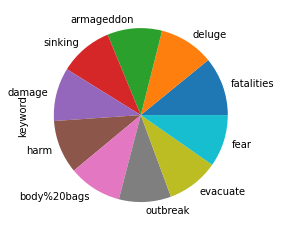

In [11]:
# Les 10 premiers keyword valeurs dans le Train
df_train['keyword'].value_counts()[:10].plot.pie();

In [12]:
# Les 10 Premiers Locations
top_location = df_train['location'].value_counts().reset_index()
top10_location = top_location.iloc[:10]
top10_location

,index,location
0,USA,104
1,New York,71
2,United States,50
3,London,45
4,Canada,29
5,Nigeria,28
6,UK,27
7,"Los Angeles, CA",26
8,India,24
9,Mumbai,22


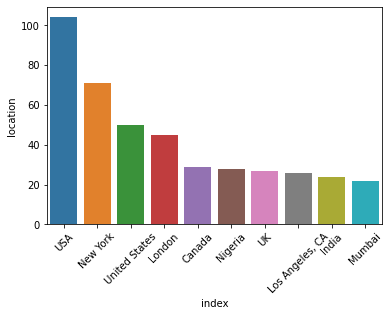

In [13]:
# Histogramme des 10 premiers pays dans le Train
ax = sns.barplot(x="index", y="location", data=top10_location)
plt.xticks(rotation=45);

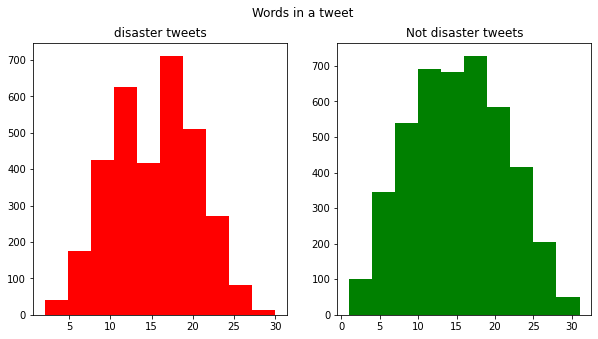

In [ ]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

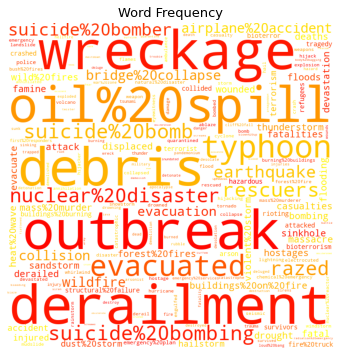

In [ ]:

word_freq_dic = df_train[df_train.target==1].keyword.value_counts().to_dict()

wordcloud = WordCloud(background_color ='white', colormap='autumn',
                      width = 700, height = 700, random_state = 42).generate_from_frequencies(word_freq_dic)

plt.figure(figsize = (6, 6)) #
plt.imshow(wordcloud)
plt.title("Word Frequency", size = 13)

plt.axis('off') 

plt.show()

In [ ]:
# Afficher les 50 premiers éléments de la colonne 'text' 

for i in range(50):
    print(df_train['text'][i])

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...
Three people died from the heat wave so far
Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding
#raining #flooding #Florida 

# Preprocessing

In [ ]:
# Fonctions pour nettoyer le texte 

#REMOVING URLs
def remove_URL(text):
    url = re.compile(r'https?://\S+')
    return url.sub(r' httpsmark ', text)


#REMOVING HTML TAGS
def remove_html(text):
    html = re.compile(r'<.*?>')
    return html.sub(r'', text)

#REMOVING symbol
def remove_atsymbol(text):
    name = re.compile(r'@\S+')
    return name.sub(r' atsymbol ', text)

#REMOVING #
def remove_hashtag(text):
    hashtag = re.compile(r'#')
    return hashtag.sub(r' hashtag ', text)

#REMOVING !
def remove_exclamation(text):
    exclamation = re.compile(r'!')
    return exclamation.sub(r' exclamation ', text)

#REMOVING ?
def remove_question(text):
    question = re.compile(r'?')
    return question.sub(r' question ', text)

#REMOVING punctuation
def remove_punc(text):
    return text.translate(str.maketrans('','',string.punctuation))

#REMOVING number
def remove_number(text):
    number = re.compile(r'\d+')
    return number.sub(r' number ', text)

#removing pictures/tags/symbols and emojis 
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r' emoji ', string)



In [ ]:
# Application des fontions sur le dataframe. colonne 'text'

df_test['text'] = df_test['text'].apply(lambda text: remove_URL(text))
df_test['text'] = df_test['text'].str.lower()
df_test['text'] = df_test['text'].apply(lambda text: remove_URL(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_html(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_atsymbol(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_hashtag(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_exclamation(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_punc(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_number(text))
df_test['text'] = df_test['text'].apply(lambda text: remove_emoji(text))

In [ ]:
# Afficher les 50 premiers éléments de la colonne 'text' après l'application des fonctions
for i in range(50):
    print(df_train['text'][i])

our deeds are the reason of this  hashtag earthquake may allah forgive us all
forest fire near la ronge sask canada
all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected
 number  people receive  hashtag wildfires evacuation orders in california 
just got sent this photo from ruby  hashtag alaska as smoke from  hashtag wildfires pours into a school 
 hashtag rockyfire update  california hwy  number  closed in both directions due to lake county fire   hashtag cafire  hashtag wildfires
 hashtag flood  hashtag disaster heavy rain causes flash flooding of streets in manitou colorado springs areas
im on top of the hill and i can see a fire in the woods
theres an emergency evacuation happening now in the building across the street
im afraid that the tornado is coming to our area
three people died from the heat wave so far
haha south tampa is getting flooded hah wait a second i live in south tampa what am i gonna do w

Tokenisation et suppression des mots qui existent dans stopwords

In [14]:
# Pipelines entrainées disponibles pour l’anglais
nlp = en_core_web_sm.load()

In [15]:
# Tokenisation et supression des mots qui existent dans  stopwords

df_train["text_tokenized"] = df_train["text"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
df_train.head()

,id,keyword,location,text,target,text_tokenized
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deed, reason, #, earthquake, may, ALLAH,..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, La, Ronge, Sask, ., Canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[all, resident, ask, ', shelter, place, ', not..."
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,"[13,000, people, receive, #, wildfire, evacuat..."
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, send, photo, Ruby, #, Alaska, smok..."


Detokenize the tokenized sentences and store them in an nlp_ready column

In [ ]:
# Tokenisation et supression des mots qui existent dans  stopwords

df_test["text_tokenized"] = df_test["text"].apply(lambda x: [token.lemma_ for token in nlp(x) if token.text not in STOP_WORDS])
df_test.head()

,id,keyword,location,text,text_tokenized
0,0,NaN,NaN,just happened a terrible car crash,"[happen, terrible, car, crash]"
1,2,NaN,NaN,heard about hashtag earthquake is different c...,"[hear, , hashtag, earthquake, different, city..."
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,"[forest, fire, spot, pond, geese, flee, street..."
3,9,NaN,NaN,apocalypse lighting hashtag spokane hashtag ...,"[apocalypse, light, , hashtag, spokane, , ha..."
4,11,NaN,NaN,typhoon soudelor kills number in china and t...,"[typhoon, soudelor, kill, , number, , china,..."


In [ ]:
# DeTokenisation du texte déjè tokenisé dans nlp_ready
detokenized_doc = []
for sentence in df_train["text_tokenized"]:
    t = ' '.join(sentence)
    detokenized_doc.append(t)

df_train['nlp_ready'] = detokenized_doc
df_train.head()

,id,keyword,location,text,target,text_tokenized,nlp_ready
0,1,NaN,NaN,our deeds are the reason of this hashtag eart...,1,"[deed, reason, , hashtag, earthquake, allah, ...",deed reason hashtag earthquake allah forgive
1,4,NaN,NaN,forest fire near la ronge sask canada,1,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,NaN,number people receive hashtag wildfires eva...,1,"[ , number, , people, receive, , hashtag, wi...",number people receive hashtag wildfire e...
4,7,NaN,NaN,just got sent this photo from ruby hashtag al...,1,"[get, send, photo, ruby, , hashtag, alaska, s...",get send photo ruby hashtag alaska smoke h...


In [ ]:
detokenized_doc = []
for sentence in df_test["text_tokenized"]:
    t = ' '.join(sentence)
    detokenized_doc.append(t)

df_test['nlp_ready'] = detokenized_doc
df_test.head()

,id,keyword,location,text,text_tokenized,nlp_ready
0,0,NaN,NaN,just happened a terrible car crash,"[happen, terrible, car, crash]",happen terrible car crash
1,2,NaN,NaN,heard about hashtag earthquake is different c...,"[hear, , hashtag, earthquake, different, city...",hear hashtag earthquake different city stay ...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,"[forest, fire, spot, pond, geese, flee, street...",forest fire spot pond geese flee street save
3,9,NaN,NaN,apocalypse lighting hashtag spokane hashtag ...,"[apocalypse, light, , hashtag, spokane, , ha...",apocalypse light hashtag spokane hashtag w...
4,11,NaN,NaN,typhoon soudelor kills number in china and t...,"[typhoon, soudelor, kill, , number, , china,...",typhoon soudelor kill number china taiwan


In [ ]:
# TF-IDF vector
vectorizer = TfidfVectorizer(smooth_idf=True)
X = vectorizer.fit_transform(df_train['nlp_ready'])
X.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Use the truncatedSVD model in order to create a topic model with 20 different topics

In [ ]:
temp = pd.DataFrame(X.toarray())

In [ ]:
temp

,0,1,2,3,4,5,6,7,8,9,...,12393,12394,12395,12396,12397,12398,12399,12400,12401,12402
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
temp

,aa,aaaa,aaaaaaallll,aaaaaand,aaarrrgghhh,aal,aampb,aampw,aan,aannnnd,...,ûïyou,ûò,ûòthe,ûòåêcnbc,ûó,ûóher,ûókody,ûónegligence,ûótech,ûówe
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7610,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7611,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
temp.shape

(7613, 12403)

In [ ]:
columns = ["topic_{}".format(i+1) for i in range(50)]

In [ ]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=200, algorithm='randomized', n_iter=100)
lsa = svd_model.fit_transform(X)

topic_encoded_df = pd.DataFrame(lsa, )
topic_encoded_df["Message"] = df_train['nlp_ready'].values
topic_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,Message
0,0.099755,-0.073894,-0.074220,-0.019255,-0.034775,-0.003717,-0.002654,0.003997,0.002145,0.003868,...,0.031326,0.026517,0.017787,-0.022147,0.050056,0.027733,-0.012228,0.012283,0.004721,deed reason hashtag earthquake allah forgive
1,0.026039,-0.004011,0.019937,-0.000786,0.033078,-0.044128,0.023687,0.079209,0.039446,-0.076396,...,-0.008977,0.030751,-0.011584,-0.052297,0.012146,0.038108,-0.002094,0.003137,0.003855,forest fire near la ronge sask canada
2,0.013190,0.003535,0.005678,-0.001336,0.013608,-0.006248,-0.001651,0.005399,-0.000250,-0.002001,...,-0.015440,0.017056,0.008888,-0.014119,0.005618,-0.019572,0.017790,0.019650,-0.019742,resident ask shelter place notify officer evac...
3,0.193474,-0.112225,0.045382,-0.018520,0.005133,-0.019756,-0.059906,0.251730,-0.061324,0.068475,...,-0.009522,0.044479,0.039269,0.014942,0.005862,-0.012854,0.010944,-0.026847,-0.028760,number people receive hashtag wildfire e...
4,0.171468,-0.112066,-0.127115,-0.030963,0.008116,-0.036168,0.006661,0.081438,-0.037666,0.031291,...,-0.009802,-0.021381,-0.020826,-0.020456,-0.023632,0.001131,0.001790,-0.015176,0.002733,get send photo ruby hashtag alaska smoke h...


In [ ]:
svd_model.explained_variance_ratio_.sum()

0.3151521585385598

In [ ]:
topic_encoded_df['associated_topic'] = topic_encoded_df[topic_encoded_df.columns[:-1]].apply(lambda x: f"topic_{np.argmax(x) + 1}", axis=1)

In [ ]:
topic_encoded_df["class_pred"] = [np.argmax(topic) for topic in lsa]
topic_encoded_df["class_pred"].value_counts()

0      1450
1       617
2       458
3       354
4       270
       ... 
86        2
167       2
58        1
160       1
76        1
Name: class_pred, Length: 196, dtype: int64

In [ ]:
topic_encoded_df["target"] = df_train.target[df_train.index]
topic_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,Message,associated_topic,class_pred,target
0,0.099755,-0.073894,-0.074220,-0.019255,-0.034775,-0.003717,-0.002654,0.003997,0.002145,0.003868,...,-0.022147,0.050056,0.027733,-0.012228,0.012283,0.004721,deed reason hashtag earthquake allah forgive,topic_1,0,1
1,0.026039,-0.004011,0.019937,-0.000786,0.033078,-0.044128,0.023687,0.079209,0.039446,-0.076396,...,-0.052297,0.012146,0.038108,-0.002094,0.003137,0.003855,forest fire near la ronge sask canada,topic_11,10,1
2,0.013190,0.003535,0.005678,-0.001336,0.013608,-0.006248,-0.001651,0.005399,-0.000250,-0.002001,...,-0.014119,0.005618,-0.019572,0.017790,0.019650,-0.019742,resident ask shelter place notify officer evac...,topic_85,84,1
3,0.193474,-0.112225,0.045382,-0.018520,0.005133,-0.019756,-0.059906,0.251730,-0.061324,0.068475,...,0.014942,0.005862,-0.012854,0.010944,-0.026847,-0.028760,number people receive hashtag wildfire e...,topic_8,7,1
4,0.171468,-0.112066,-0.127115,-0.030963,0.008116,-0.036168,0.006661,0.081438,-0.037666,0.031291,...,-0.020456,-0.023632,0.001131,0.001790,-0.015176,0.002733,get send photo ruby hashtag alaska smoke h...,topic_1,0,1


In [ ]:
topic_encoded_df['associated_topic'].value_counts()

topic_1      1450
topic_2       617
topic_3       458
topic_4       354
topic_5       270
             ... 
topic_87        2
topic_168       2
topic_59        1
topic_161       1
topic_77        1
Name: associated_topic, Length: 196, dtype: int64

In [ ]:
topic_encoded_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
X = pd.get_dummies(topic_encoded_df["associated_topic"])
y = topic_encoded_df['target']

In [ ]:
# Diviser les données X en données test et test train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
# Définir le modèle du machine learning de classification "" RandomForest"
model = RandomForestClassifier()

In [ ]:
# Model fitting

model.fit(X_train, y_train)

RandomForestClassifier()

In [ ]:
# Réaliser les prédictions sur le X_train

y_pred = model.predict(X_train)

In [ ]:
# Cross-Validation
cm = pd.crosstab(y_train, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,2586,310
1,1318,886


In [ ]:
# Réaliser les prédictions sur le X_test

y_pred_test = model.predict(X_test)

In [ ]:
y_pred_train = model.predict(X_train)

In [ ]:
cm = pd.crosstab(y_test, y_pred_test, rownames=['Classe réelle'], colnames=['Classe prédite'])
cm

Classe prédite,0,1
Classe réelle,,
0,1246,200
1,696,371


In [ ]:
print('F1 score:', f1_score(y_train, y_pred_train))
print('Precision:', precision_score(y_train, y_pred_train))
print('Recall:' ,recall_score(y_train, y_pred_train))

F1 score: 0.5211764705882352
Precision: 0.7408026755852842
Recall: 0.40199637023593465


In [ ]:
print('F1 score:', f1_score(y_test, y_pred_test))
print('Precision:', precision_score(y_test, y_pred_test))
print('Recall:' ,recall_score(y_test, y_pred_test))

F1 score: 0.452991452991453
Precision: 0.649737302977233
Recall: 0.3477038425492034


Classification Modeling

In [ ]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer.fit_on_texts(df_train["nlp_ready"])
df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train['nlp_ready'])
df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_train = df_train[df_train["len_text"]!=0]

In [ ]:
tokenizer.fit_on_texts(df_test["nlp_ready"])

tokenizer.fit_on_texts(df_test["nlp_ready"])
df_test["text_encoded"] = tokenizer.texts_to_sequences(df_test['nlp_ready'])
df_test["len_text"] = df_test["text_encoded"].apply(lambda x: len(x))
df_test = df_test[df_test["len_text"]!=0]

In [ ]:
# Padding
text_pad_train = tf.keras.preprocessing.sequence.pad_sequences(df_train['text_encoded'], padding="post")

In [ ]:
df_test.head()

,id,keyword,location,text,text_tokenized,nlp_ready,text_encoded,len_text
0,0,NaN,NaN,just happened a terrible car crash,"[happen, terrible, car, crash]",happen terrible car crash,"[136, 53, 21]",3
1,2,NaN,NaN,heard about hashtag earthquake is different c...,"[hear, , hashtag, earthquake, different, city...",hear hashtag earthquake different city stay ...,"[107, 2, 186, 137, 413, 864]",6
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...,"[forest, fire, spot, pond, geese, flee, street...",forest fire spot pond geese flee street save,"[92, 8, 584, 346, 105]",5
3,9,NaN,NaN,apocalypse lighting hashtag spokane hashtag ...,"[apocalypse, light, , hashtag, spokane, , ha...",apocalypse light hashtag spokane hashtag w...,"[264, 265, 2, 2, 89]",5
4,11,NaN,NaN,typhoon soudelor kills number in china and t...,"[typhoon, soudelor, kill, , number, , china,...",typhoon soudelor kill number china taiwan,"[395, 541, 19, 3, 740]",5


In [ ]:
text_pad_test = tf.keras.preprocessing.sequence.pad_sequences(df_test['text_encoded'], padding="post")

In [ ]:
# Traiter la variable Target 
full_ds = tf.data.Dataset.from_tensor_slices((text_pad_train, df_train['target'].values))

In [ ]:
# Train Test Split
TAKE_SIZE = int(0.7 * df_train.shape[0])

train_data = full_ds.take(TAKE_SIZE).shuffle(TAKE_SIZE)
train_data = train_data.batch(64)

test_data = full_ds.skip(TAKE_SIZE)
test_data = test_data.batch(64)

In [ ]:
#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(10000, 16),
#    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
#    tf.keras.layers.Dense(64, activation='relu'),
#    tf.keras.layers.Dense(1, activation='sigmoid')
#])

In [ ]:
 # Regardons un batch 
for text_encoded, target in train_data.take(1):
  print(text_encoded, target)

tf.Tensor(
[[ 21 278 423 ...   0   0   0]
 [  9 788   6 ...   0   0   0]
 [554  49  43 ...   0   0   0]
 ...
 [ 21 278 423 ...   0   0   0]
 [186  13 173 ...   0   0   0]
 [956 732 150 ...   0   0   0]], shape=(64, 22), dtype=int32) tf.Tensor(
[0 1 1 0 0 0 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 0
 0 1 0 1 1 0 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 0 1], shape=(64,), dtype=int64)


In [ ]:


vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[text_encoded.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and sigmoid activation
                  Dense(1, activation="sigmoid")
])

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

In [ ]:
# Model training 
model.fit(train_data,
          epochs=20)

Epoch 1/20
84/84 [==============================] - 8s 47ms/step - loss: 0.6113 - binary_accuracy: 0.6703
Epoch 2/20
84/84 [==============================] - 4s 46ms/step - loss: 0.4749 - binary_accuracy: 0.7898
Epoch 3/20
84/84 [==============================] - 3s 41ms/step - loss: 0.4166 - binary_accuracy: 0.8273
Epoch 4/20
84/84 [==============================] - 4s 44ms/step - loss: 0.3584 - binary_accuracy: 0.8570
Epoch 5/20
84/84 [==============================] - 4s 43ms/step - loss: 0.3075 - binary_accuracy: 0.8763
Epoch 6/20
84/84 [==============================] - 4s 46ms/step - loss: 0.2868 - binary_accuracy: 0.8859
Epoch 7/20
84/84 [==============================] - 3s 40ms/step - loss: 0.2577 - binary_accuracy: 0.9026
Epoch 8/20
84/84 [==============================] - 4s 43ms/step - loss: 0.2220 - binary_accuracy: 0.9162
Epoch 9/20
84/84 [==============================] - 4s 45ms/step - loss: 0.1964 - binary_accuracy: 0.9293
Epoch 10/20
84/84 [===========================

In [ ]:
predict = model.predict(test_data)
predict_labels = np.argmax(predict, axis=1)

In [ ]:
for i in range(len(predict_labels)):
  predict_labels[i] = predict_labels[i]

ids = list(df_sample_submission['id'])

submission_dic = {"id":ids, "target":predict_labels}
submission_df = pd.DataFrame.from_dict(submission_dic,orient='index')
submission_df.to_csv("kaggle_sigmoid_dense01.csv", index = False)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 64)            1004928   
                                                                 
 simple_rnn (SimpleRNN)      (None, 22, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 22, 64)            8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 22, 64)            8256      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 1

In [ ]:
y_pred = model.predict(train_data)

In [ ]:
y_pred

array([[9.8302603e-01],
       [9.9784905e-01],
       [2.0651221e-03],
       ...,
       [4.5934319e-04],
       [5.5554509e-04],
       [6.8437487e-02]], dtype=float32)

In [ ]:


vocab_size = len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1, 64, input_shape=[text_encoded.shape[1],],name="embedding"),
                  GRU(units=64, return_sequences=True), # maintains the sequential nature
                  GRU(units=32, return_sequences=False), # returns the last output
  
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  Dense(1, activation="sigmoid")
])

In [ ]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics = tf.keras.metrics.BinaryAccuracy())

In [ ]:
# Model training 
model.fit(train_data,
          epochs=20)

Epoch 1/20
84/84 [==============================] - 7s 47ms/step - loss: 0.1037 - binary_accuracy: 0.9603
Epoch 2/20
84/84 [==============================] - 4s 47ms/step - loss: 0.0990 - binary_accuracy: 0.9603
Epoch 3/20
84/84 [==============================] - 4s 46ms/step - loss: 0.1005 - binary_accuracy: 0.9588
Epoch 4/20
84/84 [==============================] - 4s 46ms/step - loss: 0.0851 - binary_accuracy: 0.9647
Epoch 5/20
84/84 [==============================] - 4s 44ms/step - loss: 0.0932 - binary_accuracy: 0.9622
Epoch 6/20
84/84 [==============================] - 5s 54ms/step - loss: 0.0895 - binary_accuracy: 0.9626
Epoch 7/20
84/84 [==============================] - 4s 46ms/step - loss: 0.0758 - binary_accuracy: 0.9679
Epoch 8/20
84/84 [==============================] - 4s 46ms/step - loss: 0.0822 - binary_accuracy: 0.9635
Epoch 9/20
84/84 [==============================] - 4s 47ms/step - loss: 0.0877 - binary_accuracy: 0.9635
Epoch 10/20
84/84 [===========================

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 22, 64)            1004928   
                                                                 
 simple_rnn (SimpleRNN)      (None, 22, 64)            8256      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 22, 64)            8256      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 22, 64)            8256      
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(10000, 16),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='Softmax'),
    tf.keras.layers.Dense(2, activation='Softmax')
])

In [ ]:
vocab_size = len(tokenizer.word_index)
model = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1, 64, input_shape=[text_encoded.shape[1],],name="embedding"),
                  # Gobal average pooling
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                   SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                    SimpleRNN(units=64, return_sequences=True), # maintains the sequential nature
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  Dense(8, activation='relu'),

                  # output layer with as many neurons as the number of classes
                  # for the target variable and sigmoid activation
                  Dense(2, activation="Softmax")
])


In [ ]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = tf.keras.metrics.SparseCategoricalAccuracy())

In [ ]:
# Model training 
model.fit(train_data,
          epochs=20)

Epoch 1/20
84/84 [==============================] - 10s 62ms/step - loss: 0.6377 - sparse_categorical_accuracy: 0.6406
Epoch 2/20
84/84 [==============================] - 5s 62ms/step - loss: 0.5322 - sparse_categorical_accuracy: 0.7647
Epoch 3/20
84/84 [==============================] - 7s 78ms/step - loss: 0.4778 - sparse_categorical_accuracy: 0.7964
Epoch 4/20
84/84 [==============================] - 5s 61ms/step - loss: 0.4360 - sparse_categorical_accuracy: 0.8164
Epoch 5/20
84/84 [==============================] - 5s 62ms/step - loss: 0.4215 - sparse_categorical_accuracy: 0.8226
Epoch 6/20
84/84 [==============================] - 5s 61ms/step - loss: 0.3987 - sparse_categorical_accuracy: 0.8367
Epoch 7/20
84/84 [==============================] - 5s 59ms/step - loss: 0.3852 - sparse_categorical_accuracy: 0.8406
Epoch 8/20
84/84 [==============================] - 5s 60ms/step - loss: 0.3711 - sparse_categorical_accuracy: 0.8496
Epoch 9/20
84/84 [==============================] - 5s 

In [ ]:
predict = model.predict(test_data)
predict_labels = np.argmax(predict, axis=1)

In [ ]:
for i in range(len(predict_labels)):
  predict_labels[i] = predict_labels[i]

ids = list(df_sample_submission['id'])

submission_dic = {"id":ids, "target":predict_labels}
submission_df = pd.DataFrame.from_dict(submission_dic,orient='index')
submission_df.to_csv("kaggle_01.csv", index = False)


In [ ]:
df_sample_submission

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0
